# Latent Neural ODEs for Irregular Time Series

## A Pedagogical Introduction

This notebook introduces **Latent Neural ODEs**, a powerful framework for modeling **irregularly-sampled time series** data. Unlike standard Neural ODEs, Latent ODEs work in a latent space and can handle:

- **Irregular sampling**: Observations at arbitrary time points
- **Missing data**: Not all variables observed at each time
- **Forecasting**: Predicting future values from past observations

**Key Components:**
1. **Encoder (ODE-RNN)**: Processes observations backward in time using an ODE-RNN
2. **Latent ODE**: Models continuous dynamics in latent space
3. **Decoder**: Maps latent states back to observations

**References:**
- Rubanova et al. (2019) "Latent ODEs for Irregularly-Sampled Time Series" - NeurIPS 2019

## 1. Mathematical Background

### Architecture Overview

Given observations $\{(t_i, x_i)\}_{i=1}^{N}$ at irregular times:

1. **Encode**: Run ODE-RNN backward to get approximate posterior $q(\mathbf{z}_0 | \{x_i, t_i\})$
2. **Sample**: Draw initial latent state $\mathbf{z}_0 \sim q(\mathbf{z}_0)$
3. **Evolve**: Solve ODE forward: $\mathbf{z}(t) = \mathbf{z}_0 + \int_0^t f(\mathbf{z}(s), s, \theta) ds$
4. **Decode**: Map latent states to observations: $\hat{x}(t) = g(\mathbf{z}(t))$

### ODE-RNN Encoder

Between observations, the hidden state evolves according to an ODE:
$$\mathbf{h}(t_{i-1}) = \text{ODESolve}(\mathbf{h}(t_i), f, t_i, t_{i-1})$$

At observation times, the RNN updates:
$$\mathbf{h}'(t_i) = \text{RNNCell}(\mathbf{h}(t_i), x_i)$$

In [1]:
# Install required packages if needed
# !pip install torchdiffeq

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchdiffeq import odeint
from torch.distributions import Normal
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 2. Building Latent Neural ODE Components

### 2.1 ODE Function (Latent Dynamics)

In [3]:
class LatentODEFunc(nn.Module):
    """Defines the latent dynamics dz/dt = f(z, t)."""
    def __init__(self, latent_dim, hidden_dim=64):
        super(LatentODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, latent_dim)
        )
        self.nfe = 0
        
    def forward(self, t, z):
        self.nfe += 1
        return self.net(z)

### 2.2 ODE-RNN Encoder

The encoder processes observations **backward in time** using an ODE between observations and GRU updates at observation times.

In [4]:
class ODERNNEncoder(nn.Module):
    """ODE-RNN encoder that processes irregular time series backward in time."""
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(ODERNNEncoder, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        # GRU cell for updating hidden state at observation times
        self.gru_cell = nn.GRUCell(input_dim, hidden_dim)
        
        # ODE function for hidden state dynamics between observations
        self.ode_func = LatentODEFunc(hidden_dim, hidden_dim)
        
        # Map final hidden state to latent distribution parameters
        self.hidden_to_latent = nn.Linear(hidden_dim, 2 * latent_dim)  # mean and log_var
        
    def forward(self, x, t, mask=None):
        """
        Encode irregular time series into latent distribution.
        
        Args:
            x: Observations [batch_size, seq_len, input_dim]
            t: Time points [batch_size, seq_len] or [seq_len]
            mask: Binary mask for valid observations [batch_size, seq_len]
        Returns:
            mean, log_var: Parameters of latent distribution
        """
        batch_size = x.shape[0]
        seq_len = x.shape[1]
        
        if mask is None:
            mask = torch.ones(batch_size, seq_len).to(x.device)
        
        # Handle both shared and per-sample time points
        if t.dim() == 1:
            t = t.unsqueeze(0).expand(batch_size, -1)
        
        # Initialize hidden state
        h = torch.zeros(batch_size, self.hidden_dim).to(x.device)
        
        # Process backward in time
        for i in reversed(range(seq_len)):
            # Get current observation and time
            x_i = x[:, i, :]  # [batch_size, input_dim]
            t_i = t[:, i]      # [batch_size]
            mask_i = mask[:, i]  # [batch_size]
            
            # If not the last observation (going backward), evolve hidden state with ODE
            if i < seq_len - 1:
                t_prev = t[:, i + 1]
                # Evolve from t_prev to t_i (backward in actual time, but forward in processing)
                dt = t_prev - t_i  # Time difference (positive since we're going backward)
                
                # For simplicity, use a single ODE solve with average dt
                # In practice, you'd batch this more carefully
                if dt.mean() > 0:
                    t_span = torch.tensor([0., dt.mean().item()]).to(x.device)
                    h = odeint(self.ode_func, h, t_span, method='euler')[-1]
            
            # Update hidden state with observation (if valid)
            h_new = self.gru_cell(x_i, h)
            # Only update where mask is 1
            h = mask_i.unsqueeze(-1) * h_new + (1 - mask_i.unsqueeze(-1)) * h
        
        # Map to latent distribution
        latent_params = self.hidden_to_latent(h)
        mean = latent_params[:, :self.latent_dim]
        log_var = latent_params[:, self.latent_dim:]
        
        return mean, log_var

### 2.3 Decoder

The decoder maps latent states to observations.

In [5]:
class Decoder(nn.Module):
    """Decoder that maps latent states to observations."""
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, z):
        """Decode latent state to observation.
        
        Args:
            z: Latent state [..., latent_dim]
        Returns:
            Predicted observation [..., output_dim]
        """
        return self.net(z)

### 2.4 Complete Latent ODE Model

In [6]:
class LatentODE(nn.Module):
    """Complete Latent ODE model for irregular time series."""
    def __init__(self, input_dim=1, hidden_dim=32, latent_dim=8):
        super(LatentODE, self).__init__()
        
        self.latent_dim = latent_dim
        
        # Encoder: ODE-RNN
        self.encoder = ODERNNEncoder(input_dim, hidden_dim, latent_dim)
        
        # Latent ODE dynamics
        self.latent_ode_func = LatentODEFunc(latent_dim, hidden_dim)
        
        # Decoder
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)
        
    def reparameterize(self, mean, log_var):
        """Reparameterization trick for VAE."""
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x_obs, t_obs, t_pred, mask=None):
        """
        Forward pass: encode observations, evolve latent state, decode predictions.
        
        Args:
            x_obs: Observed values [batch_size, obs_len, input_dim]
            t_obs: Observation times [batch_size, obs_len] or [obs_len]
            t_pred: Prediction times [pred_len]
            mask: Optional mask for observations
        Returns:
            predictions: Predicted values at t_pred
            mean, log_var: Latent distribution parameters
        """
        # Encode observations
        mean, log_var = self.encoder(x_obs, t_obs, mask)
        
        # Sample initial latent state
        z0 = self.reparameterize(mean, log_var)
        
        # Solve ODE forward in time
        # Start from t=0 (or first observation time)
        self.latent_ode_func.nfe = 0
        z_pred = odeint(self.latent_ode_func, z0, t_pred, method='dopri5', 
                        rtol=1e-3, atol=1e-3)
        # z_pred shape: [pred_len, batch_size, latent_dim]
        
        # Decode to observations
        # Transpose to [batch_size, pred_len, latent_dim]
        z_pred = z_pred.permute(1, 0, 2)
        predictions = self.decoder(z_pred)
        
        return predictions, mean, log_var
    
    def forecast(self, x_obs, t_obs, t_future, mask=None):
        """Forecast future values given observations."""
        self.eval()
        with torch.no_grad():
            # Encode
            mean, log_var = self.encoder(x_obs, t_obs, mask)
            # Use mean for deterministic prediction
            z0 = mean
            
            # Evolve
            z_future = odeint(self.latent_ode_func, z0, t_future, method='dopri5')
            z_future = z_future.permute(1, 0, 2)
            
            # Decode
            predictions = self.decoder(z_future)
        
        return predictions

## 3. Generating Irregular Time Series Data

We'll create synthetic univariate time series with:
- **Irregular sampling**: Random time intervals
- **Known dynamics**: Sinusoidal + trend for ground truth
- **Noise**: Observational noise

In [7]:
def generate_irregular_time_series(n_samples=100, max_obs=30, t_max=10.0, noise_std=0.1):
    """
    Generate irregular univariate time series with sinusoidal dynamics.
    
    True function: x(t) = A * sin(w*t + phi) + B*t + C
    """
    data = []
    
    for _ in range(n_samples):
        # Random parameters for each series
        A = np.random.uniform(0.5, 2.0)      # Amplitude
        w = np.random.uniform(0.5, 2.0)      # Frequency
        phi = np.random.uniform(0, 2*np.pi)  # Phase
        B = np.random.uniform(-0.2, 0.2)     # Trend
        C = np.random.uniform(-1, 1)         # Offset
        
        # Generate irregular time points
        n_obs = np.random.randint(15, max_obs + 1)
        t = np.sort(np.random.uniform(0, t_max, n_obs))
        
        # Generate observations
        x_true = A * np.sin(w * t + phi) + B * t + C
        x_obs = x_true + noise_std * np.random.randn(n_obs)
        
        # Store parameters for evaluation
        params = {'A': A, 'w': w, 'phi': phi, 'B': B, 'C': C}
        
        data.append({
            't': t,
            'x': x_obs,
            'x_true': x_true,
            'params': params
        })
    
    return data

# Generate data
n_train = 200
n_test = 50
t_max = 10.0

train_data = generate_irregular_time_series(n_train, max_obs=25, t_max=t_max, noise_std=0.1)
test_data = generate_irregular_time_series(n_test, max_obs=25, t_max=t_max, noise_std=0.1)

print(f"Generated {n_train} training sequences")
print(f"Generated {n_test} test sequences")
print(f"\nExample sequence:")
print(f"  Time points: {len(train_data[0]['t'])} observations")
print(f"  Time range: [{train_data[0]['t'][0]:.2f}, {train_data[0]['t'][-1]:.2f}]")

Generated 200 training sequences
Generated 50 test sequences

Example sequence:
  Time points: 17 observations
  Time range: [0.01, 9.92]


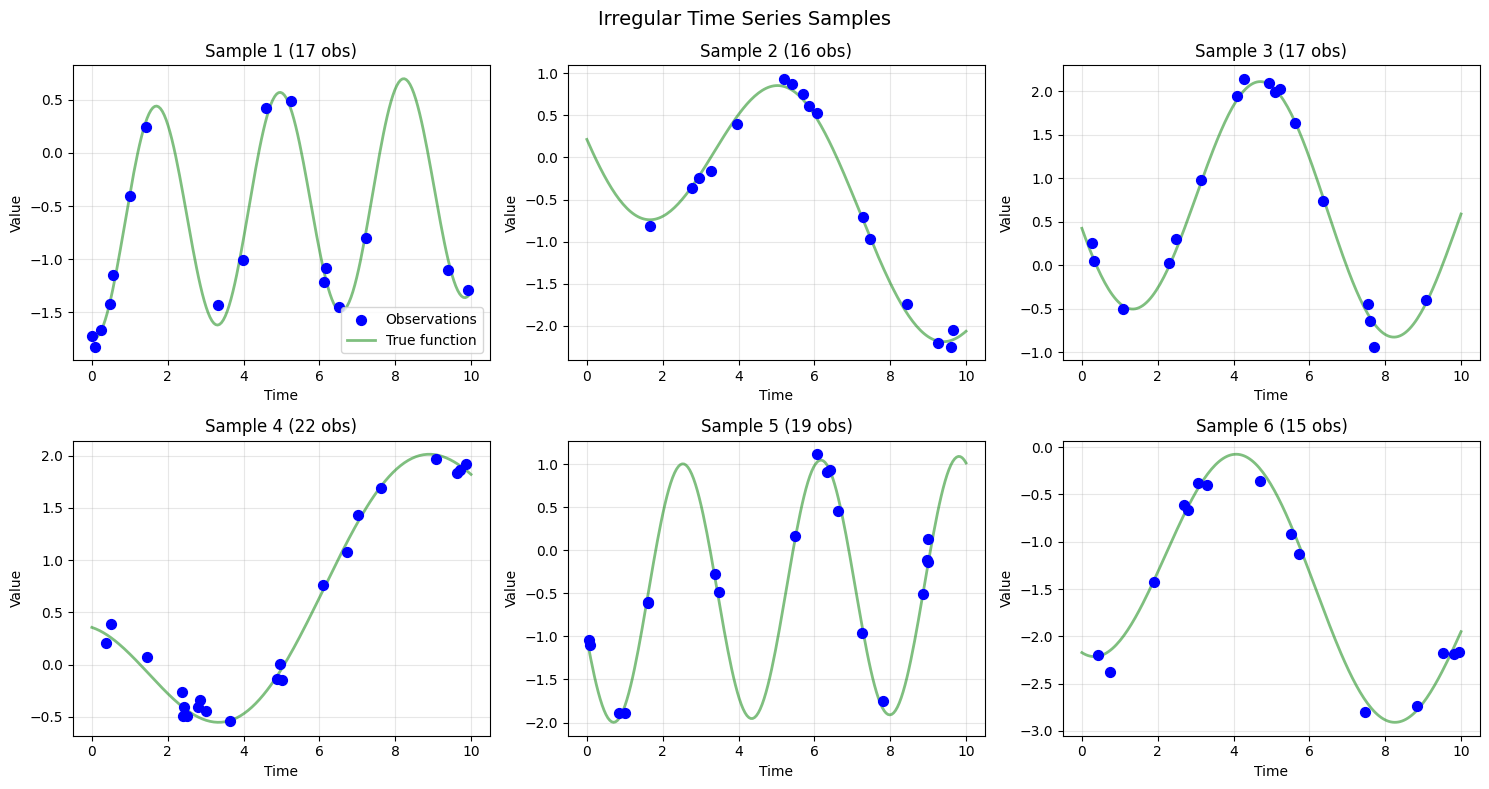

In [8]:
# Visualize some example time series
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i in range(6):
    ax = axes[i]
    sample = train_data[i]
    
    # Plot observations
    ax.scatter(sample['t'], sample['x'], c='blue', s=50, zorder=5, label='Observations')
    
    # Plot true function
    t_dense = np.linspace(0, t_max, 200)
    p = sample['params']
    x_true_dense = p['A'] * np.sin(p['w'] * t_dense + p['phi']) + p['B'] * t_dense + p['C']
    ax.plot(t_dense, x_true_dense, 'g-', alpha=0.5, linewidth=2, label='True function')
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.set_title(f'Sample {i+1} ({len(sample["t"])} obs)')
    ax.grid(True, alpha=0.3)
    if i == 0:
        ax.legend()

plt.suptitle('Irregular Time Series Samples', fontsize=14)
plt.tight_layout()
plt.show()

### 3.1 Prepare Data for Training

We need to pad sequences to the same length for batching.

In [9]:
def prepare_batch(data_list, obs_ratio=0.7, device='cpu'):
    """
    Prepare a batch of irregular time series.
    Split each series into observation and prediction parts.
    
    Args:
        data_list: List of time series dictionaries
        obs_ratio: Fraction of time points to use as observations
    Returns:
        x_obs, t_obs, mask_obs: Padded observations
        x_target, t_target: Target values for prediction
    """
    batch_size = len(data_list)
    
    # Find max lengths
    max_obs_len = max(int(len(d['t']) * obs_ratio) for d in data_list)
    max_pred_len = max(len(d['t']) - int(len(d['t']) * obs_ratio) for d in data_list)
    
    # Initialize tensors
    x_obs = torch.zeros(batch_size, max_obs_len, 1)
    t_obs = torch.zeros(batch_size, max_obs_len)
    mask_obs = torch.zeros(batch_size, max_obs_len)
    
    x_target = torch.zeros(batch_size, max_pred_len, 1)
    t_target = torch.zeros(batch_size, max_pred_len)
    mask_target = torch.zeros(batch_size, max_pred_len)
    
    for i, d in enumerate(data_list):
        n_total = len(d['t'])
        n_obs = int(n_total * obs_ratio)
        
        # Observations
        x_obs[i, :n_obs, 0] = torch.tensor(d['x'][:n_obs], dtype=torch.float32)
        t_obs[i, :n_obs] = torch.tensor(d['t'][:n_obs], dtype=torch.float32)
        mask_obs[i, :n_obs] = 1.0
        
        # Targets (future observations)
        n_pred = n_total - n_obs
        x_target[i, :n_pred, 0] = torch.tensor(d['x'][n_obs:], dtype=torch.float32)
        t_target[i, :n_pred] = torch.tensor(d['t'][n_obs:], dtype=torch.float32)
        mask_target[i, :n_pred] = 1.0
    
    return (x_obs.to(device), t_obs.to(device), mask_obs.to(device),
            x_target.to(device), t_target.to(device), mask_target.to(device))

# Test the preparation
x_obs, t_obs, mask_obs, x_target, t_target, mask_target = prepare_batch(train_data[:4], device=device)
print(f"Observation shape: {x_obs.shape}")
print(f"Target shape: {x_target.shape}")
print(f"Observation times shape: {t_obs.shape}")
print(f"Target times shape: {t_target.shape}")

Observation shape: torch.Size([4, 15, 1])
Target shape: torch.Size([4, 7, 1])
Observation times shape: torch.Size([4, 15])
Target times shape: torch.Size([4, 7])


## 4. Training the Latent ODE

We train with a VAE-style loss:
- **Reconstruction loss**: MSE between predictions and targets
- **KL divergence**: Regularize latent distribution

In [10]:
def compute_loss(predictions, targets, mask, mean, log_var, kl_weight=0.01):
    """
    Compute VAE loss: reconstruction + KL divergence.
    
    Args:
        predictions: Predicted values [batch_size, pred_len, dim]
        targets: True values [batch_size, pred_len, dim]
        mask: Valid positions [batch_size, pred_len]
        mean, log_var: Latent distribution parameters
        kl_weight: Weight for KL term (beta in beta-VAE)
    """
    # Reconstruction loss (MSE on valid positions)
    mse = ((predictions - targets) ** 2) * mask.unsqueeze(-1)
    recon_loss = mse.sum() / mask.sum()
    
    # KL divergence: KL(q(z) || p(z)) where p(z) = N(0, I)
    kl_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp(), dim=1)
    kl_loss = kl_loss.mean()
    
    total_loss = recon_loss + kl_weight * kl_loss
    
    return total_loss, recon_loss, kl_loss

In [11]:
def train_latent_ode(model, train_data, epochs=100, batch_size=32, lr=0.001, kl_weight=0.01):
    """Train the Latent ODE model."""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
    
    train_losses = []
    recon_losses = []
    kl_losses = []
    
    n_batches = len(train_data) // batch_size
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        epoch_recon = 0
        epoch_kl = 0
        
        # Shuffle data
        indices = np.random.permutation(len(train_data))
        
        for i in range(n_batches):
            batch_indices = indices[i * batch_size:(i + 1) * batch_size]
            batch_data = [train_data[j] for j in batch_indices]
            
            # Prepare batch
            x_obs, t_obs, mask_obs, x_target, t_target, mask_target = prepare_batch(
                batch_data, obs_ratio=0.7, device=device
            )
            
            # Create time points for ODE integration
            # We need to integrate from t=0 to all target times
            # For simplicity, use a fixed grid
            t_all = torch.linspace(0, t_max, 50).to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            predictions, mean, log_var = model(x_obs, t_obs, t_all, mask_obs)
            
            # Extract predictions at target times (approximate by interpolation)
            # For simplicity, we'll predict at all times and compute loss
            # Here we match predictions to targets based on closest time
            pred_at_target = torch.zeros_like(x_target)
            for b in range(x_target.shape[0]):
                for j in range(x_target.shape[1]):
                    if mask_target[b, j] > 0:
                        # Find closest time in t_all
                        idx = torch.argmin(torch.abs(t_all - t_target[b, j]))
                        pred_at_target[b, j] = predictions[b, idx]
            
            # Compute loss
            loss, recon, kl = compute_loss(pred_at_target, x_target, mask_target, 
                                           mean, log_var, kl_weight)
            
            loss.backward()
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            epoch_loss += loss.item()
            epoch_recon += recon.item()
            epoch_kl += kl.item()
        
        scheduler.step()
        
        train_losses.append(epoch_loss / n_batches)
        recon_losses.append(epoch_recon / n_batches)
        kl_losses.append(epoch_kl / n_batches)
        
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Total: {train_losses[-1]:.4f} | "
                  f"Recon: {recon_losses[-1]:.4f} | KL: {kl_losses[-1]:.4f}")
    
    return train_losses, recon_losses, kl_losses

In [20]:
# Create and train the model
model = LatentODE(
    input_dim=1,
    hidden_dim=32,
    latent_dim=8
).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")
print("\nTraining Latent ODE...")

train_losses, recon_losses, kl_losses = train_latent_ode(
    model, train_data, epochs=1000, batch_size=16, lr=0.005, kl_weight=0.01
)

Model parameters: 8985

Training Latent ODE...
Epoch 20/1000 | Total: 1.5737 | Recon: 1.5323 | KL: 4.1393
Epoch 40/1000 | Total: 1.3633 | Recon: 1.3292 | KL: 3.4074
Epoch 60/1000 | Total: 1.1344 | Recon: 1.1000 | KL: 3.4487
Epoch 80/1000 | Total: 0.9119 | Recon: 0.8738 | KL: 3.8109
Epoch 100/1000 | Total: 0.8219 | Recon: 0.7824 | KL: 3.9481
Epoch 120/1000 | Total: 0.7012 | Recon: 0.6644 | KL: 3.6752
Epoch 140/1000 | Total: 0.6734 | Recon: 0.6361 | KL: 3.7360
Epoch 160/1000 | Total: 0.6235 | Recon: 0.5878 | KL: 3.5712
Epoch 180/1000 | Total: 0.6008 | Recon: 0.5664 | KL: 3.4414
Epoch 200/1000 | Total: 0.5933 | Recon: 0.5546 | KL: 3.8678
Epoch 220/1000 | Total: 0.5293 | Recon: 0.4899 | KL: 3.9460
Epoch 240/1000 | Total: 0.5366 | Recon: 0.4952 | KL: 4.1471
Epoch 260/1000 | Total: 0.5382 | Recon: 0.4942 | KL: 4.4067
Epoch 280/1000 | Total: 0.5172 | Recon: 0.4724 | KL: 4.4731
Epoch 300/1000 | Total: 0.5111 | Recon: 0.4649 | KL: 4.6143
Epoch 320/1000 | Total: 0.5102 | Recon: 0.4628 | KL: 4.74

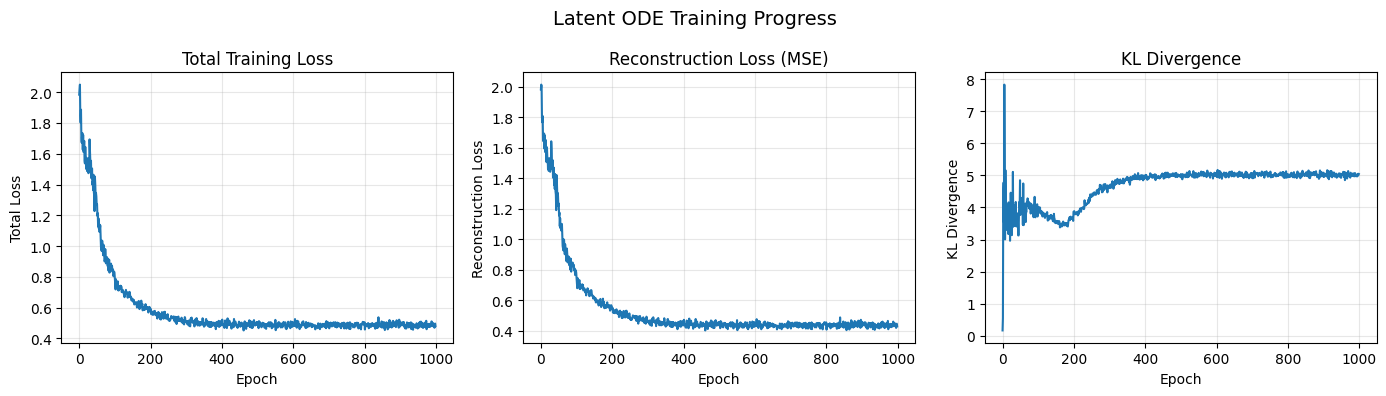

In [21]:
# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

axes[0].plot(train_losses)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Total Loss')
axes[0].set_title('Total Training Loss')
axes[0].grid(True, alpha=0.3)

axes[1].plot(recon_losses)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Reconstruction Loss')
axes[1].set_title('Reconstruction Loss (MSE)')
axes[1].grid(True, alpha=0.3)

axes[2].plot(kl_losses)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('KL Divergence')
axes[2].set_title('KL Divergence')
axes[2].grid(True, alpha=0.3)

plt.suptitle('Latent ODE Training Progress', fontsize=14)
plt.tight_layout()
plt.show()

## 5. Forecasting with Latent ODE

Let's evaluate the model's forecasting ability on test data.

In [22]:
def evaluate_forecasting(model, test_data, obs_ratio=0.7):
    """Evaluate forecasting performance on test set."""
    model.eval()
    
    mse_list = []
    predictions_list = []
    
    with torch.no_grad():
        for sample in test_data:
            n_total = len(sample['t'])
            n_obs = int(n_total * obs_ratio)
            
            # Prepare single sample
            x_obs = torch.tensor(sample['x'][:n_obs], dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)
            t_obs = torch.tensor(sample['t'][:n_obs], dtype=torch.float32).unsqueeze(0).to(device)
            
            # Prediction times (including future)
            t_pred = torch.linspace(0, t_max, 100).to(device)
            
            # Forecast
            pred = model.forecast(x_obs, t_obs, t_pred)
            pred = pred.squeeze().cpu().numpy()
            
            # Evaluate on future points
            t_future = sample['t'][n_obs:]
            x_future_true = sample['x'][n_obs:]
            
            # Interpolate predictions to future times
            pred_at_future = np.interp(t_future, t_pred.cpu().numpy(), pred)
            
            mse = np.mean((pred_at_future - x_future_true) ** 2)
            mse_list.append(mse)
            
            predictions_list.append({
                't_pred': t_pred.cpu().numpy(),
                'pred': pred,
                't_obs': sample['t'][:n_obs],
                'x_obs': sample['x'][:n_obs],
                't_future': t_future,
                'x_future': x_future_true,
                'params': sample['params']
            })
    
    return np.mean(mse_list), np.std(mse_list), predictions_list

mean_mse, std_mse, predictions = evaluate_forecasting(model, test_data)
print(f"Test MSE: {mean_mse:.6f} +/- {std_mse:.6f}")
print(f"Test RMSE: {np.sqrt(mean_mse):.6f}")

Test MSE: 2.041643 +/- 3.031336
Test RMSE: 1.428861


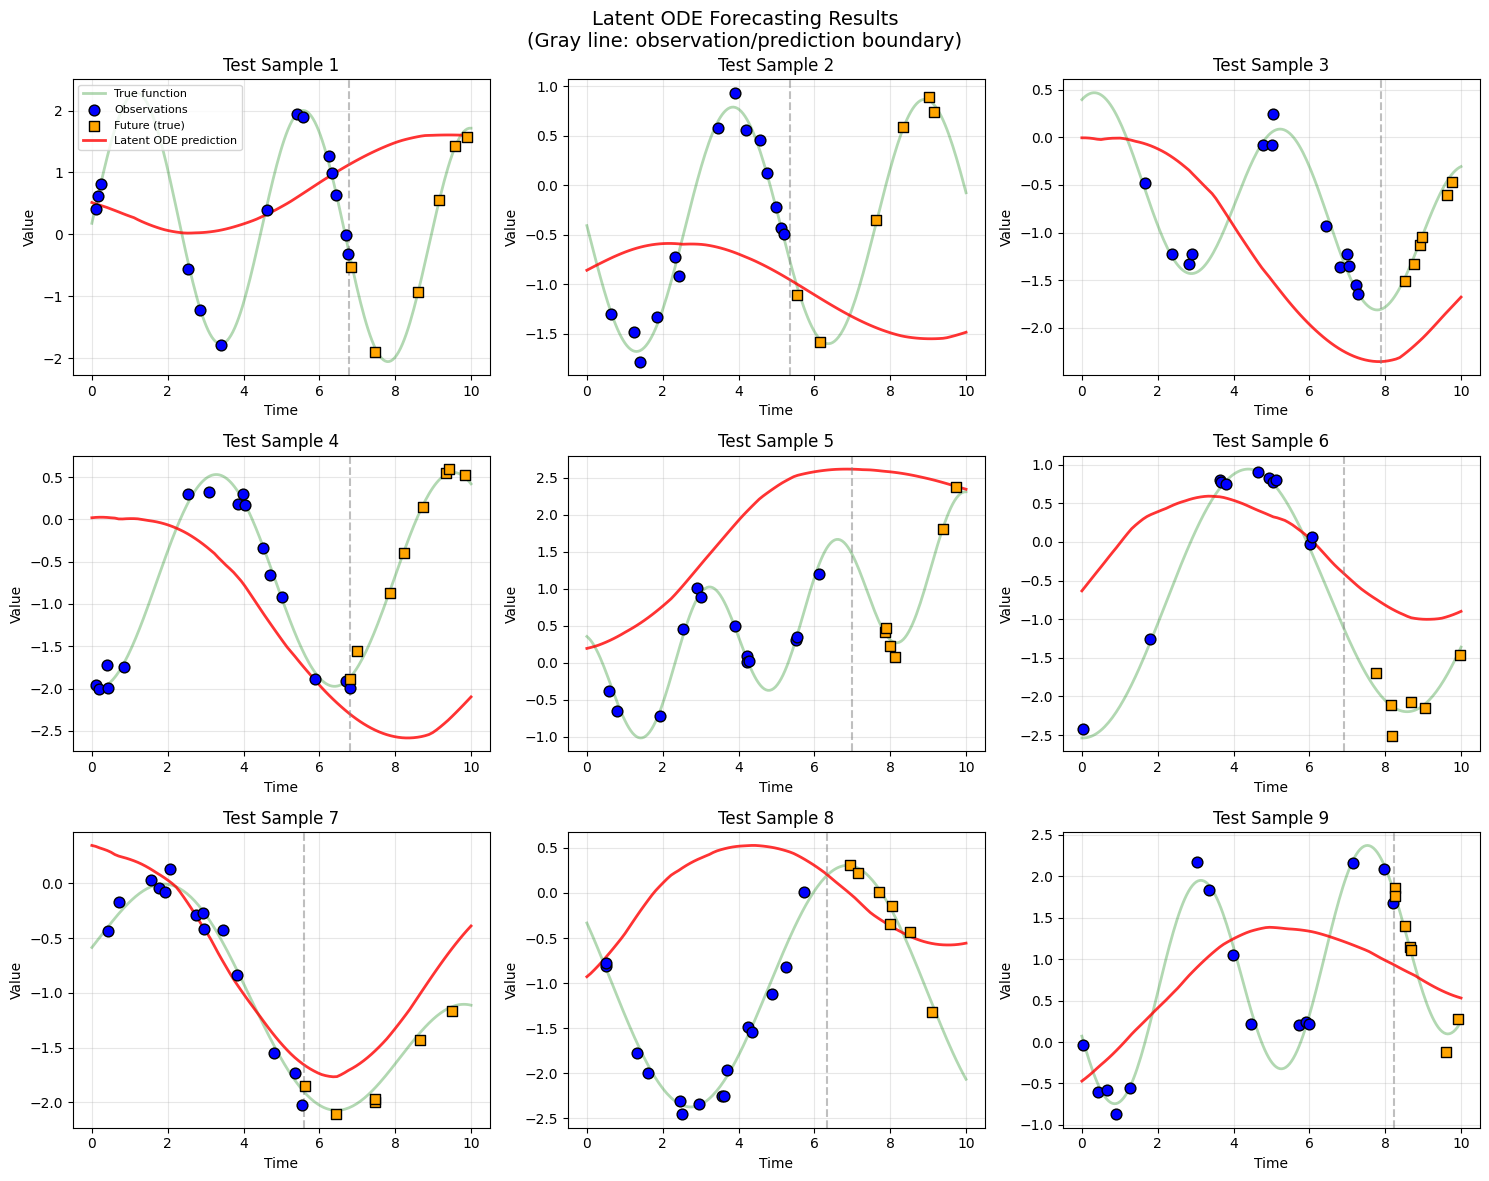

In [23]:
# Visualize forecasting results
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i in range(9):
    ax = axes[i]
    pred_data = predictions[i]
    
    # Plot true function
    p = pred_data['params']
    t_dense = np.linspace(0, t_max, 200)
    x_true_dense = p['A'] * np.sin(p['w'] * t_dense + p['phi']) + p['B'] * t_dense + p['C']
    ax.plot(t_dense, x_true_dense, 'g-', alpha=0.3, linewidth=2, label='True function')
    
    # Plot observations
    ax.scatter(pred_data['t_obs'], pred_data['x_obs'], c='blue', s=60, 
               zorder=5, label='Observations', edgecolors='black')
    
    # Plot future ground truth
    ax.scatter(pred_data['t_future'], pred_data['x_future'], c='orange', s=60, 
               zorder=5, label='Future (true)', marker='s', edgecolors='black')
    
    # Plot predictions
    ax.plot(pred_data['t_pred'], pred_data['pred'], 'r-', linewidth=2, 
            alpha=0.8, label='Latent ODE prediction')
    
    # Mark observation/prediction boundary
    if len(pred_data['t_obs']) > 0 and len(pred_data['t_future']) > 0:
        boundary = (pred_data['t_obs'][-1] + pred_data['t_future'][0]) / 2
        ax.axvline(boundary, color='gray', linestyle='--', alpha=0.5)
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.set_title(f'Test Sample {i+1}')
    ax.grid(True, alpha=0.3)
    if i == 0:
        ax.legend(loc='upper left', fontsize=8)

plt.suptitle('Latent ODE Forecasting Results\n(Gray line: observation/prediction boundary)', fontsize=14)
plt.tight_layout()
plt.show()

## 6. Comparison with Simple Baselines

Let's compare with simple baselines to understand the value of Latent ODEs.

In [24]:
def baseline_last_value(test_data, obs_ratio=0.7):
    """Baseline: predict last observed value."""
    mse_list = []
    for sample in test_data:
        n_total = len(sample['t'])
        n_obs = int(n_total * obs_ratio)
        
        last_value = sample['x'][n_obs - 1]
        future_values = sample['x'][n_obs:]
        
        mse = np.mean((future_values - last_value) ** 2)
        mse_list.append(mse)
    
    return np.mean(mse_list), np.std(mse_list)

def baseline_linear_extrapolation(test_data, obs_ratio=0.7):
    """Baseline: linear extrapolation from last two observations."""
    mse_list = []
    for sample in test_data:
        n_total = len(sample['t'])
        n_obs = int(n_total * obs_ratio)
        
        if n_obs < 2:
            continue
        
        # Fit line to last few observations
        n_fit = min(5, n_obs)
        t_fit = sample['t'][n_obs-n_fit:n_obs]
        x_fit = sample['x'][n_obs-n_fit:n_obs]
        
        # Linear regression
        coeffs = np.polyfit(t_fit, x_fit, 1)
        
        # Predict future
        t_future = sample['t'][n_obs:]
        x_pred = np.polyval(coeffs, t_future)
        x_true = sample['x'][n_obs:]
        
        mse = np.mean((x_pred - x_true) ** 2)
        mse_list.append(mse)
    
    return np.mean(mse_list), np.std(mse_list)

# Evaluate baselines
mse_last, std_last = baseline_last_value(test_data)
mse_linear, std_linear = baseline_linear_extrapolation(test_data)

print("Forecasting Performance Comparison:")
print("=" * 50)
print(f"Last Value Baseline:      MSE = {mse_last:.6f} +/- {std_last:.6f}")
print(f"Linear Extrapolation:     MSE = {mse_linear:.6f} +/- {std_linear:.6f}")
print(f"Latent ODE:               MSE = {mean_mse:.6f} +/- {std_mse:.6f}")
print("=" * 50)
print(f"Improvement over Last Value:  {((mse_last - mean_mse) / mse_last * 100):.1f}%")
print(f"Improvement over Linear:      {((mse_linear - mean_mse) / mse_linear * 100):.1f}%")

Forecasting Performance Comparison:
Last Value Baseline:      MSE = 1.500849 +/- 1.556018
Linear Extrapolation:     MSE = 11.645353 +/- 20.669303
Latent ODE:               MSE = 2.041643 +/- 3.031336
Improvement over Last Value:  -36.0%
Improvement over Linear:      82.5%


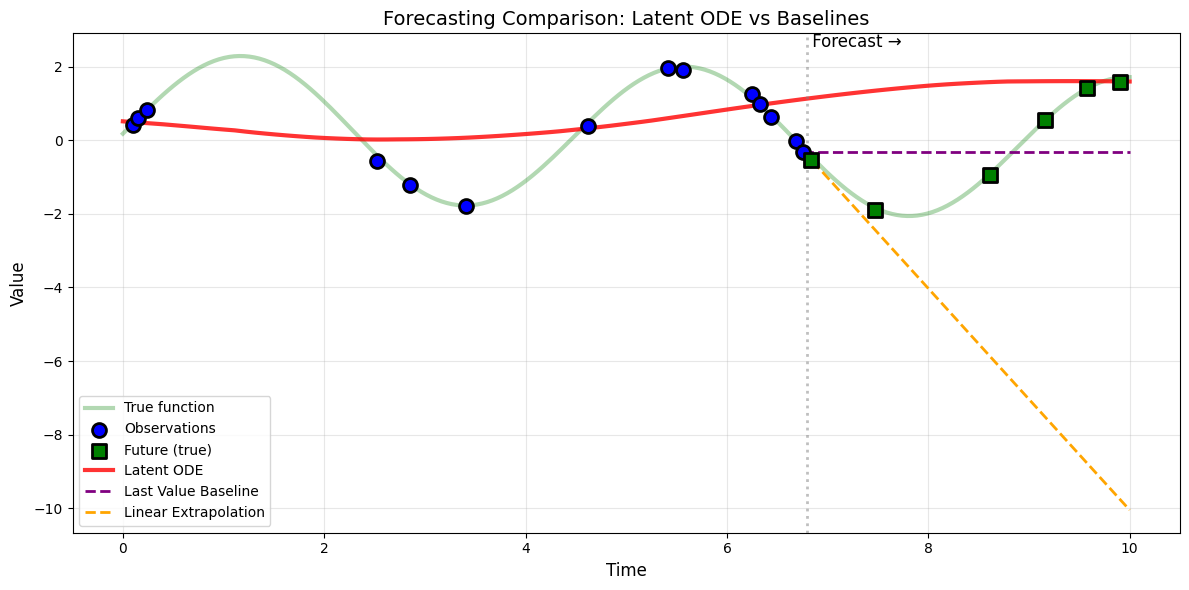

In [25]:
# Visualize comparison on a single example
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

sample_idx = 0
pred_data = predictions[sample_idx]
sample = test_data[sample_idx]
n_obs = len(pred_data['t_obs'])

# True function
p = pred_data['params']
t_dense = np.linspace(0, t_max, 200)
x_true_dense = p['A'] * np.sin(p['w'] * t_dense + p['phi']) + p['B'] * t_dense + p['C']
ax.plot(t_dense, x_true_dense, 'g-', alpha=0.3, linewidth=3, label='True function')

# Observations
ax.scatter(pred_data['t_obs'], pred_data['x_obs'], c='blue', s=100, 
           zorder=5, label='Observations', edgecolors='black', linewidths=2)

# Future ground truth
ax.scatter(pred_data['t_future'], pred_data['x_future'], c='green', s=100, 
           zorder=5, label='Future (true)', marker='s', edgecolors='black', linewidths=2)

# Latent ODE prediction
ax.plot(pred_data['t_pred'], pred_data['pred'], 'r-', linewidth=3, 
        alpha=0.8, label='Latent ODE')

# Last value baseline
last_val = pred_data['x_obs'][-1]
ax.hlines(last_val, pred_data['t_obs'][-1], t_max, colors='purple', 
          linestyles='--', linewidth=2, label='Last Value Baseline')

# Linear extrapolation
n_fit = min(5, n_obs)
t_fit = pred_data['t_obs'][-n_fit:]
x_fit = pred_data['x_obs'][-n_fit:]
coeffs = np.polyfit(t_fit, x_fit, 1)
t_extrap = np.linspace(pred_data['t_obs'][-1], t_max, 50)
x_extrap = np.polyval(coeffs, t_extrap)
ax.plot(t_extrap, x_extrap, 'orange', linestyle='--', linewidth=2, label='Linear Extrapolation')

# Boundary
boundary = (pred_data['t_obs'][-1] + pred_data['t_future'][0]) / 2
ax.axvline(boundary, color='gray', linestyle=':', alpha=0.5, linewidth=2)
ax.text(boundary, ax.get_ylim()[1], ' Forecast →', va='top', ha='left', fontsize=12)

ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
ax.set_title('Forecasting Comparison: Latent ODE vs Baselines', fontsize=14)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()